# **NAME: PARTHA SAKHA PAUL**

# **ROLL: MA23M016**

    CS6910_assignment 2


**Importing all essential libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

**Image data transformation function for training and validation**

In [5]:
def prepare_data_loaders(data_augment, batch_size=64):
    if data_augment:
        # With data augmentation
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.450, 0.470, 0.490], std=[0.200, 0.220, 0.240]),
        ])
    else:
        # Without data augmentation
        train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        ])

    
    # Load datasets
    train_data = datasets.ImageFolder(root='/kaggle/input/inaturalist-12k/inaturalist_12K/train', transform=train_transform)
#     validation_dataset = datasets.ImageFolder(root='/kaggle/input/inaturalist/inaturalist_12K/val', transform=val_transform)
#     print(len(train_data))
    # print(train_data[9998])
    # Creating data indices for training and validation splits:
    dataset_size = len(train_data)  #9999
    indices = list(range(dataset_size)) #[0,1,...,9998]
    split = int(np.floor(0.2 * dataset_size))  #1999
#     print(split)
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]  # [1999,...,9998] , [0,...,1998]
    # print((val_indices))

    # Creating data samplers and loaders
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    # print(type(train_sampler))

    train_loader = DataLoader(train_data, batch_size=64, sampler=train_sampler)
    # print(len(train_loader))
    validation_loader = DataLoader(train_data, batch_size=64, sampler=valid_sampler)
    # print(*validation_loader)
    # Prepare data loaders
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, validation_loader

**Image size transformation function for training and test data**

In [25]:
# this is for data transformation for test dataset
def prepare_data_loaders_for_test(data_augment, batch_size=64):
    if data_augment:
        # With data augmentation
        transform_train = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.450, 0.470, 0.490], std=[0.200, 0.220, 0.240]),
        ])
    else:
        # Without data augmentation
        transform_train = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])
    
    
    # Load datasets
    train_data = datasets.ImageFolder(root='/kaggle/input/inaturalist-12k/inaturalist_12K/train', transform=transform_train)
    test_data = datasets.ImageFolder(root='/kaggle/input/inaturalist-12k/inaturalist_12K/val', transform=transform_train)  # applying same transformation on both dataset
    
    # Creating data loaders directly without splitting since val_data is already a separate dataset
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)  
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)  # for test dataset we dont need to shuffle but needed for visualization then it takes randomely

    return train_loader, test_loader

train_loader, test_loader = prepare_data_loaders_for_test('false')

**Activation functions dictionary and my_CNN class bulding**

In [28]:
activation_functions = {
            'relu': F.relu,
            'gelu': F.gelu,
            'silu': F.silu,
            'mish': F.mish
        }

# defining a class CNN that inherits from nn.Module which is PyTorch's base class for all neural network
class my_CNN(nn.Module):
    def __init__(self, num_classes=10, num_filters=[32, 64, 128, 256, 512], filter_sizes=[3, 3, 3, 3, 3], activation_fn='relu', num_neurons_dense = 256, dropout_rate = 0.5, use_batchnorm='no'):
        super(my_CNN, self).__init__()
        # Initializing class variables
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_sizes = filter_sizes
        self.activation_fn = activation_functions[activation_fn]
        self.num_neurons_dense = num_neurons_dense
        self.dropout_rate = dropout_rate
        # Convert yes/no to boolean
        self.use_batchnorm = True if use_batchnorm.lower() == 'yes' else False

        # Creating convolution layers using ModuleList
        self.conv_layers = nn.ModuleList()
        # List to hold batchnorm layers for conv
        self.batchnorm_layers_conv = nn.ModuleList()
        in_channels = 3  # since, input images are RGB
        for out_channels, kernel_size in zip(num_filters, filter_sizes):
            # a convolution layer with in-out channels and kernel size
            conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
            self.conv_layers.append(conv_layer)
            if self.use_batchnorm:
                # Add a Batchnorm2d layer for each conv layer
                self.batchnorm_layers_conv.append(nn.BatchNorm2d(out_channels))
            # Update in_channels for the next layer
            in_channels = out_channels

            
        # Defining dropout before it's used
        self.dropout = nn.Dropout(dropout_rate)
        # find the size needed to flatten the conv layer outputs, initializing the dense layer accordingly
        self.init_flatten_size(input_shape=(3, 224, 224))  # input images are 224x224 RGB images
        # initializing the dense layer from flatten size
        self.dense = nn.Linear(self.flatten_size, num_neurons_dense)
        if self.use_batchnorm:
             # Batchnorm1d for the dense layer
            self.batchnorm_dense = nn.BatchNorm1d(num_neurons_dense)
        # output layer: maps from the dense layer to the number of classes.
        self.out = nn.Linear(num_neurons_dense, num_classes)


    def init_flatten_size(self, input_shape):
        # to disable gradient calculations for speed up this computation
        with torch.no_grad():
            # a dummy input tensor of the correct shape
            input_tensor = torch.zeros(1, *input_shape)
            # Forward prop through the conv layers to find output size
            output = self.forward_conv_layers(input_tensor)
            # total number of output features is the flat size needed for the dense layer input
            self.flatten_size = output.numel()

    # a function for sequentially passing input through all convolutional layers and applying activation and pooling
    def forward_conv_layers(self, x):
        # Convolution layer
        for i, conv in enumerate(self.conv_layers):
            x = conv(x)  # Convolution operation
            if self.use_batchnorm:
                # Apply batchnorm if enabled
                x = self.batchnorm_layers_conv[i](x)
            x = self.activation_fn(x)  # Apply the specified activation function
            x = F.max_pool2d(x, 2)  # max pooling with a kernel size of 2
            x = self.dropout(x)  # Apply dropout after pooling
        return x

    # forward method defines how the input tensor is transformed through the model
    def forward(self, x):
        # Passing input through the convolution blocks
        x = self.forward_conv_layers(x)
        # Flattening the output for the dense layer
        x = torch.flatten(x, 1)   # Flatten the output for the dense layer
        # Dense layer
        x = self.dense(x)
        if self.use_batchnorm:
            # Apply batchnorm if enabled to dense layer
            x = self.batchnorm_dense(x)
        x = self.activation_fn(x)
        # Applying dropout before the final layer
        x = self.dropout(x)
        # Output layer
        x = self.out(x)
        return x
    

    # Define a method for visualizing predictions made by the model.
    def visualize_predictions(self, data_loader, device, num_images=30):
        # Put the model in evaluation mode
        self.eval()
        # counter to keep track of how many images have been displayed
        images_occur = 0

        # Set the figure size for plotting
        plt.figure(figsize=(15, 30))

        # Use the torch.no_grad() to disable gradient calculation
        with torch.no_grad():
            # Iterate over batches of data from the data loader
            for images, labels in data_loader:
                # Move the images and labels to the specified device (CPU or GPU)
                images, labels = images.to(device), labels.to(device)
                # Forward pass: Compute the predicted outputs by passing images to the model
                outputs = self(images)
                # the predicted classes by finding the index with the maximum logit value for each image
                _, predicted = torch.max(outputs, 1)

                # Convert the images, labels, and predictions back to numpy arrays for visualization
                images = images.cpu().numpy()
                labels = labels.cpu().numpy()
                predicted = predicted.cpu().numpy()

                # Iterate over each image in the batch.
                for i in range(images.shape[0]):
                    # If the specified number of images (num_images) have already been displayed, exit the loop.
                    if images_occur >= num_images:
                        return
                    # Dynamically calculate the number of rows
                    num_rows = num_images // 3 + (num_images % 3 > 0)
                    # Create a subplot for each image 
                    plt.subplot(num_rows, 3, images_occur + 1)
                    # Display the image
                    plt.imshow(np.transpose(images[i], (1, 2, 0)))
                    # Add a title to each subplot indicating the true and predicted labels
                    plt.title(f'True: {labels[i]}, Pred: {predicted[i]}')
                    plt.axis('off')
                    # Increment the counter
                    images_occur += 1

        # display the figure.
        plt.show()


    # Method for training and evaluating the model
    def train_and_evaluate(self, train_loader, validation_loader, n_epochs=10, lr=0.001, device=None):
        if device is None:
            # setting up CUDA if available, otherwise, using CPU
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.to(device)  # transferring the model to the selected device (GPU or CPU)

        # Initializing the loss function and optimizer
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)  # self.parameters() is a built-in method provided by PyTorch's nn.Module that collects all the learnable parameters of our model

        # Training loop
        for epoch in range(n_epochs):
            self.train()  # Setting model to training mode
            training_loss = 0.0
            # tracking number of correctly predicted instances
            correct_train = 0
            # tracking total number of instances
            total_train = 0

            # Iterate over the training data
            for images, labels in train_loader:
                # transferring images and labels to the current device (GPU or CPU)
                images, labels = images.to(device), labels.to(device)
                # clearing the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward prop: computing predicted outputs by passing inputs to the model
                outputs = self(images)
                # calculating the loss between predicted and true labels
                loss = loss_function(outputs, labels)
                # Backward prop: computing gradient of the loss with respect to parameters
                loss.backward()
                # optimization step (parameter update)
                optimizer.step()
                # updating running training loss
                training_loss += loss.item() * images.size(0)
                # converting output probabilities to predicted class
                _, predicted_train = torch.max(outputs.data, 1)
                # updating total number of instances
                total_train += labels.size(0)
                # updating correctly predicted instances
                correct_train += (predicted_train == labels).sum().item()

            # average loss over an epoch
            training_loss /= len(train_loader.sampler)
            # train accuracy
            train_accuracy = correct_train / total_train

            # Evaluation phase
            self.eval()  # Setting model to evaluation mode
            # initializing the validation loss for the epoch
            validation_loss = 0.0
            # tracking number of correctly predicted instances
            correct_val = 0
            # tracking total number of instances
            total_val = 0
            # disable gradient calculation for validation, saving memory and computations
            with torch.no_grad():
                # iterating over the validation data loader
                for images, labels in validation_loader:
                    # transferring images and labels to the current device (GPU or CPU)
                    images, labels = images.to(device), labels.to(device)
                    # Forward prop: computing predicted outputs by passing inputs to the model
                    outputs = self(images)
                    # calculating the loss between predicted and true labels
                    loss = loss_function(outputs, labels)
                    # updating running validation loss
                    validation_loss += loss.item() * images.size(0)
                    # converting output probabilities to predicted class
                    _, predicted = torch.max(outputs.data, 1)
                    # updating total number of instances
                    total_val += labels.size(0)
                    # updating correctly predicted instances
                    correct_val += (predicted == labels).sum().item()

            # average validation loss over an epoch
            validation_loss /= len(validation_loader.sampler)
            # validation accuracy
            val_accuracy = correct_val / total_val

            # printing training and validation results
#             print(f'Epoch {epoch+1}, Training Loss: {training_loss:.4f}, Training Accuracy: {train_accuracy*100:.2f}, \nValidation Loss: {validation_loss:.4f}, Validation Accuracy: {val_accuracy*100:.2f}')
            # printing training and testing results
            print(f'Epoch {epoch+1}, Training Loss: {training_loss:.4f}, Training Accuracy: {train_accuracy*100:.2f}, \nTest Loss: {validation_loss:.4f}, Test Accuracy: {val_accuracy*100:.2f}')
            # for validating the accuracy with validation data
#             wandb.log({"train_accuracy": train_accuracy * 100, "training_loss": training_loss})
#             wandb.log({"val_accuracy": val_accuracy * 100, "val_loss": validation_loss})
            # for testing the accuracy with test data
            wandb.log({"train_accuracy": train_accuracy * 100, "training_loss": training_loss})
            wandb.log({"test_accuracy": val_accuracy * 100, "test_loss": validation_loss})    # this val_accuracy actually gives test_accuracy when we pass the test data instead of validation data

        # After the last epoch, visualize predictions on test data
        self.visualize_predictions(test_loader, device)


# model with parameters
model = my_CNN(num_classes=10,
                  num_filters=[32, 64, 128, 256, 512],
                  filter_sizes=[7,9,7,9,9],
                  activation_fn='relu',
                  num_neurons_dense=512,
                  dropout_rate = 0.5, 
                  use_batchnorm='yes')

print(model)

# model.train_and_evaluate(train_loader, validation_loader, n_epochs=10, lr=0.001)

my_CNN(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(128, 256, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(256, 512, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  )
  (batchnorm_layers_conv): ModuleList(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (dense): Linear(in_features=512, out_feature

**Importing WANDB for sweep**

In [4]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

key = input('Enter your API:')
wandb.login(key=key)  #25c2257eaf6c22aa056893db14da4ee2bf0a531a

Enter your API: 25c2257eaf6c22aa056893db14da4ee2bf0a531a


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

**Hyperparameter tuning for training data and validation data**

In [4]:
# this is for hyperparameter tuning in training dataset
sweep_config = {
    'method': 'bayes',
    'name' : 'cnn kaggle find best 3',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'num_filters': {
            'values': [[128,128,64,64,32], [64, 64, 64, 64, 64], [256, 128, 64, 32, 16], [256,256,128,64,32],[256,128,64,32,16]] 
        },
        'filter_sizes':{
            'values': [[7,7,5,3,3], [7,7,5,5,3], [7,7,7,5,3], [7,7,7,3,3], [5,5,5,5,5]]
        },
        'activation_fn': {
            'values': ['relu', 'gelu', 'silu', 'mish']
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
        'batch_norm':{
            'values': ['false','true']
        },
        'data_augment': {
            'values': ['false','true']
        },
        'num_neurons_dense':{
            'values': [256,128]
        }
    }
}

sweep_id = wandb.sweep(sweep = sweep_config, project="Deep_learning_A2")

Create sweep with ID: e8aph0yp
Sweep URL: https://wandb.ai/parthasakhapaul/Deep_learning_A2/sweeps/e8aph0yp


In [9]:
# this is for hyperparameter tuning in training dataset
def main():
    # Initialize a new wandb run
    with wandb.init() as run:
        run_name = "-ac-"+wandb.config.activation_fn+"-filters-"+str(wandb.config.num_filters)+"-filt_size-"+str(wandb.config.filter_sizes)+"-dropout-"+str(wandb.config.dropout)+"-batch_norm-"+wandb.config.batch_norm+"-data_aug-"+wandb.config.data_augment+"-num_neurons_dense-"+str(wandb.config.num_neurons_dense)
        wandb.run.name=run_name
        # Model object creation
        model = my_CNN(num_classes = 10,
                  num_filters = wandb.config.num_filters,
                  filter_sizes = wandb.config.filter_sizes,
                  activation_fn = wandb.config.activation_fn,
                  num_neurons_dense = wandb.config.num_neurons_dense,
                  dropout_rate = wandb.config.dropout,
                  use_batchnorm = wandb.config.batch_norm)
        
        data_augment = wandb.config.data_augment
        train_loader, validation_loader = prepare_data_loaders(data_augment)
        # Model training
        model.train_and_evaluate(train_loader, validation_loader, n_epochs=7, lr=0.001)        

wandb.agent(sweep_id, function=main, count=20)
wandb.finish()

wandb: Agent Starting Run: jdbuzmjr with config:
wandb: 	activation_fn: mish
wandb: 	batch_norm: true
wandb: 	data_augment: true
wandb: 	dropout: 0.2
wandb: 	filter_sizes: [7, 7, 7, 3, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	num_neurons_dense: 128
wandb: Currently logged in as: parthasakhapaul. Use `wandb login --relogin` to force relogin


Epoch 1, Training Loss: 2.2191, Training Accuracy: 17.11, 
Validation Loss: 2.1617, Validation Accuracy: 20.26
Epoch 2, Training Loss: 2.1925, Training Accuracy: 19.35, 
Validation Loss: 2.1993, Validation Accuracy: 19.61
Epoch 3, Training Loss: 2.1542, Training Accuracy: 21.11, 
Validation Loss: 2.1991, Validation Accuracy: 19.31
Epoch 4, Training Loss: 2.1495, Training Accuracy: 21.43, 
Validation Loss: 2.1629, Validation Accuracy: 19.56
Epoch 5, Training Loss: 2.1490, Training Accuracy: 21.39, 
Validation Loss: 2.1887, Validation Accuracy: 17.71
Epoch 6, Training Loss: 2.1340, Training Accuracy: 21.96, 
Validation Loss: 2.1642, Validation Accuracy: 19.86
Epoch 7, Training Loss: 2.1250, Training Accuracy: 21.98, 
Validation Loss: 2.1509, Validation Accuracy: 20.61


train_accuracy,▁▄▇▇▇██
training_loss,█▆▃▃▃▂▁
val_accuracy,▇▆▅▅▁▆█
val_loss,▃██▃▆▃▁
train_accuracy,21.975
training_loss,2.125
val_accuracy,20.61031
val_loss,2.15092


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bkiwxx90 with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: false
wandb: 	data_augment: false
wandb: 	dropout: 0.2
wandb: 	filter_sizes: [5, 5, 5, 5, 5]
wandb: 	num_filters: [64, 64, 64, 64, 64]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2798, Training Accuracy: 12.89, 
Validation Loss: 2.2826, Validation Accuracy: 11.21
Epoch 2, Training Loss: 2.2374, Training Accuracy: 15.99, 
Validation Loss: 2.2059, Validation Accuracy: 17.76
Epoch 3, Training Loss: 2.2089, Training Accuracy: 18.10, 
Validation Loss: 2.1932, Validation Accuracy: 17.96
Epoch 4, Training Loss: 2.2031, Training Accuracy: 17.91, 
Validation Loss: 2.1995, Validation Accuracy: 18.21
Epoch 5, Training Loss: 2.2015, Training Accuracy: 17.85, 
Validation Loss: 2.2127, Validation Accuracy: 18.06
Epoch 6, Training Loss: 2.2018, Training Accuracy: 18.09, 
Validation Loss: 2.1815, Validation Accuracy: 18.16
Epoch 7, Training Loss: 2.1878, Training Accuracy: 18.40, 
Validation Loss: 2.1791, Validation Accuracy: 18.31


train_accuracy,▁▅█▇▇██
training_loss,█▅▃▂▂▂▁
val_accuracy,▁▇█████
val_loss,█▃▂▂▃▁▁
train_accuracy,18.4
training_loss,2.18777
val_accuracy,18.30915
val_loss,2.17906


wandb: Agent Starting Run: l4fp1fi5 with config:
wandb: 	activation_fn: mish
wandb: 	batch_norm: true
wandb: 	data_augment: false
wandb: 	dropout: 0.2
wandb: 	filter_sizes: [7, 7, 7, 3, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2422, Training Accuracy: 16.34, 
Validation Loss: 2.2163, Validation Accuracy: 17.41
Epoch 2, Training Loss: 2.1982, Training Accuracy: 19.02, 
Validation Loss: 2.1660, Validation Accuracy: 20.76
Epoch 3, Training Loss: 2.1837, Training Accuracy: 19.74, 
Validation Loss: 2.1587, Validation Accuracy: 20.21
Epoch 4, Training Loss: 2.1703, Training Accuracy: 20.01, 
Validation Loss: 2.1414, Validation Accuracy: 21.96
Epoch 5, Training Loss: 2.1429, Training Accuracy: 21.77, 
Validation Loss: 2.1413, Validation Accuracy: 22.31
Epoch 6, Training Loss: 2.1382, Training Accuracy: 22.31, 
Validation Loss: 2.1034, Validation Accuracy: 23.91
Epoch 7, Training Loss: 2.1283, Training Accuracy: 22.76, 
Validation Loss: 2.0940, Validation Accuracy: 24.36


train_accuracy,▁▄▅▅▇██
training_loss,█▅▄▄▂▂▁
val_accuracy,▁▄▄▆▆██
val_loss,█▅▅▄▄▂▁
train_accuracy,22.7625
training_loss,2.12829
val_accuracy,24.36218
val_loss,2.09402


wandb: Agent Starting Run: tk2blhw5 with config:
wandb: 	activation_fn: silu
wandb: 	batch_norm: false
wandb: 	data_augment: false
wandb: 	dropout: 0.2
wandb: 	filter_sizes: [7, 7, 5, 3, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2321, Training Accuracy: 17.18, 
Validation Loss: 2.2342, Validation Accuracy: 16.76
Epoch 2, Training Loss: 2.1953, Training Accuracy: 20.36, 
Validation Loss: 2.1787, Validation Accuracy: 20.61
Epoch 3, Training Loss: 2.1567, Training Accuracy: 21.36, 
Validation Loss: 2.1687, Validation Accuracy: 21.16
Epoch 4, Training Loss: 2.1418, Training Accuracy: 21.99, 
Validation Loss: 2.1080, Validation Accuracy: 24.01
Epoch 5, Training Loss: 2.1267, Training Accuracy: 22.76, 
Validation Loss: 2.1456, Validation Accuracy: 21.41
Epoch 6, Training Loss: 2.1043, Training Accuracy: 23.31, 
Validation Loss: 2.0546, Validation Accuracy: 26.11
Epoch 7, Training Loss: 2.1129, Training Accuracy: 23.12, 
Validation Loss: 2.0601, Validation Accuracy: 25.21


train_accuracy,▁▅▆▆▇██
training_loss,█▆▄▃▂▁▁
val_accuracy,▁▄▄▆▄█▇
val_loss,█▆▅▃▅▁▁
train_accuracy,23.125
training_loss,2.11286
val_accuracy,25.21261
val_loss,2.0601


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rhuvty8p with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: true
wandb: 	data_augment: false
wandb: 	dropout: 0.3
wandb: 	filter_sizes: [7, 7, 7, 5, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	num_neurons_dense: 256


Epoch 1, Training Loss: 2.2688, Training Accuracy: 14.35, 
Validation Loss: 2.2872, Validation Accuracy: 13.06
Epoch 2, Training Loss: 2.2279, Training Accuracy: 15.46, 
Validation Loss: 2.2360, Validation Accuracy: 15.46
Epoch 3, Training Loss: 2.2133, Training Accuracy: 16.86, 
Validation Loss: 2.2350, Validation Accuracy: 16.11
Epoch 4, Training Loss: 2.2051, Training Accuracy: 17.18, 
Validation Loss: 2.2191, Validation Accuracy: 16.56
Epoch 5, Training Loss: 2.2029, Training Accuracy: 17.51, 
Validation Loss: 2.2191, Validation Accuracy: 15.96
Epoch 6, Training Loss: 2.2053, Training Accuracy: 17.91, 
Validation Loss: 2.2140, Validation Accuracy: 16.26
Epoch 7, Training Loss: 2.1927, Training Accuracy: 17.91, 
Validation Loss: 2.2094, Validation Accuracy: 17.01


train_accuracy,▁▃▆▇▇██
training_loss,█▄▃▂▂▂▁
val_accuracy,▁▅▆▇▆▇█
val_loss,█▃▃▂▂▁▁
train_accuracy,17.9125
training_loss,2.19268
val_accuracy,17.0085
val_loss,2.20939


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bjl0snh9 with config:
wandb: 	activation_fn: silu
wandb: 	batch_norm: true
wandb: 	data_augment: false
wandb: 	dropout: 0.3
wandb: 	filter_sizes: [7, 7, 5, 3, 3]
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	num_neurons_dense: 256


Epoch 1, Training Loss: 2.2214, Training Accuracy: 17.72, 
Validation Loss: 2.2256, Validation Accuracy: 17.01
Epoch 2, Training Loss: 2.2139, Training Accuracy: 18.76, 
Validation Loss: 2.2013, Validation Accuracy: 16.76
Epoch 3, Training Loss: 2.1731, Training Accuracy: 20.29, 
Validation Loss: 2.1514, Validation Accuracy: 21.06
Epoch 4, Training Loss: 2.1521, Training Accuracy: 20.97, 
Validation Loss: 2.1752, Validation Accuracy: 19.16
Epoch 5, Training Loss: 2.1397, Training Accuracy: 21.32, 
Validation Loss: 2.1057, Validation Accuracy: 23.56
Epoch 6, Training Loss: 2.1322, Training Accuracy: 22.40, 
Validation Loss: 2.1569, Validation Accuracy: 20.91
Epoch 7, Training Loss: 2.1138, Training Accuracy: 23.20, 
Validation Loss: 2.1625, Validation Accuracy: 20.26


train_accuracy,▁▂▄▅▆▇█
training_loss,██▅▃▃▂▁
val_accuracy,▁▁▅▃█▅▅
val_loss,█▇▄▅▁▄▄
train_accuracy,23.2
training_loss,2.11383
val_accuracy,20.26013
val_loss,2.16255


wandb: Agent Starting Run: ob1ekhu3 with config:
wandb: 	activation_fn: mish
wandb: 	batch_norm: true
wandb: 	data_augment: true
wandb: 	dropout: 0.3
wandb: 	filter_sizes: [7, 7, 5, 3, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2194, Training Accuracy: 17.82, 
Validation Loss: 2.2052, Validation Accuracy: 19.76
Epoch 2, Training Loss: 2.1709, Training Accuracy: 20.09, 
Validation Loss: 2.1490, Validation Accuracy: 21.26
Epoch 3, Training Loss: 2.1400, Training Accuracy: 22.45, 
Validation Loss: 2.1038, Validation Accuracy: 23.21
Epoch 4, Training Loss: 2.1220, Training Accuracy: 22.70, 
Validation Loss: 2.0975, Validation Accuracy: 24.06
Epoch 5, Training Loss: 2.1105, Training Accuracy: 23.88, 
Validation Loss: 2.0938, Validation Accuracy: 24.51
Epoch 6, Training Loss: 2.0949, Training Accuracy: 24.75, 
Validation Loss: 2.0862, Validation Accuracy: 26.31
Epoch 7, Training Loss: 2.1062, Training Accuracy: 23.56, 
Validation Loss: 2.1109, Validation Accuracy: 23.16


train_accuracy,▁▃▆▆▇█▇
training_loss,█▅▄▃▂▁▂
val_accuracy,▁▃▅▆▆█▅
val_loss,█▅▂▂▁▁▂
train_accuracy,23.5625
training_loss,2.10621
val_accuracy,23.16158
val_loss,2.11087


wandb: Agent Starting Run: g0k5a0al with config:
wandb: 	activation_fn: mish
wandb: 	batch_norm: false
wandb: 	data_augment: true
wandb: 	dropout: 0.2
wandb: 	filter_sizes: [7, 7, 7, 5, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]
wandb: 	num_neurons_dense: 256


Epoch 1, Training Loss: 2.2499, Training Accuracy: 16.89, 
Validation Loss: 2.2101, Validation Accuracy: 18.96
Epoch 2, Training Loss: 2.1880, Training Accuracy: 19.95, 
Validation Loss: 2.2017, Validation Accuracy: 17.46
Epoch 3, Training Loss: 2.1871, Training Accuracy: 18.68, 
Validation Loss: 2.2020, Validation Accuracy: 17.11
Epoch 4, Training Loss: 2.2111, Training Accuracy: 17.62, 
Validation Loss: 2.1811, Validation Accuracy: 19.01
Epoch 5, Training Loss: 2.1808, Training Accuracy: 18.94, 
Validation Loss: 2.1560, Validation Accuracy: 19.31
Epoch 6, Training Loss: 2.1799, Training Accuracy: 19.19, 
Validation Loss: 2.1584, Validation Accuracy: 19.86
Epoch 7, Training Loss: 2.1644, Training Accuracy: 20.19, 
Validation Loss: 2.1663, Validation Accuracy: 18.71


train_accuracy,▁▇▅▃▅▆█
training_loss,█▃▃▅▂▂▁
val_accuracy,▆▂▁▆▇█▅
val_loss,█▇▇▄▁▁▂
train_accuracy,20.1875
training_loss,2.16444
val_accuracy,18.70935
val_loss,2.16629


wandb: Agent Starting Run: 07qoriu3 with config:
wandb: 	activation_fn: relu
wandb: 	batch_norm: false
wandb: 	data_augment: true
wandb: 	dropout: 0.3
wandb: 	filter_sizes: [7, 7, 5, 3, 3]
wandb: 	num_filters: [256, 256, 128, 64, 32]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2992, Training Accuracy: 12.61, 
Validation Loss: 2.2797, Validation Accuracy: 14.96
Epoch 2, Training Loss: 2.2401, Training Accuracy: 17.00, 
Validation Loss: 2.2304, Validation Accuracy: 15.56
Epoch 3, Training Loss: 2.1954, Training Accuracy: 17.65, 
Validation Loss: 2.2018, Validation Accuracy: 19.21
Epoch 4, Training Loss: 2.1777, Training Accuracy: 19.31, 
Validation Loss: 2.1658, Validation Accuracy: 19.31
Epoch 5, Training Loss: 2.1693, Training Accuracy: 19.56, 
Validation Loss: 2.1505, Validation Accuracy: 19.71
Epoch 6, Training Loss: 2.1669, Training Accuracy: 20.08, 
Validation Loss: 2.1808, Validation Accuracy: 20.66
Epoch 7, Training Loss: 2.1508, Training Accuracy: 20.96, 
Validation Loss: 2.1590, Validation Accuracy: 20.41


train_accuracy,▁▅▅▇▇▇█
training_loss,█▅▃▂▂▂▁
val_accuracy,▁▂▆▆▇██
val_loss,█▅▄▂▁▃▁
train_accuracy,20.9625
training_loss,2.15079
val_accuracy,20.41021
val_loss,2.15896


wandb: Agent Starting Run: iqac9fhw with config:
wandb: 	activation_fn: mish
wandb: 	batch_norm: false
wandb: 	data_augment: true
wandb: 	dropout: 0.3
wandb: 	filter_sizes: [7, 7, 5, 5, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2437, Training Accuracy: 16.94, 
Validation Loss: 2.1916, Validation Accuracy: 20.36
Epoch 2, Training Loss: 2.2220, Training Accuracy: 17.44, 
Validation Loss: 2.2247, Validation Accuracy: 19.71
Epoch 3, Training Loss: 2.1838, Training Accuracy: 20.05, 
Validation Loss: 2.1462, Validation Accuracy: 22.01
Epoch 4, Training Loss: 2.1633, Training Accuracy: 20.45, 
Validation Loss: 2.1919, Validation Accuracy: 20.31
Epoch 5, Training Loss: 2.1657, Training Accuracy: 20.80, 
Validation Loss: 2.1148, Validation Accuracy: 22.51
Epoch 6, Training Loss: 2.1424, Training Accuracy: 22.14, 
Validation Loss: 2.1361, Validation Accuracy: 21.86
Epoch 7, Training Loss: 2.1351, Training Accuracy: 23.20, 
Validation Loss: 2.0998, Validation Accuracy: 25.06


train_accuracy,▁▂▄▅▅▇█
training_loss,█▇▄▃▃▁▁
val_accuracy,▂▁▄▂▅▄█
val_loss,▆█▄▆▂▃▁
train_accuracy,23.2
training_loss,2.1351
val_accuracy,25.06253
val_loss,2.09976


wandb: Agent Starting Run: znqhwkdh with config:
wandb: 	activation_fn: mish
wandb: 	batch_norm: true
wandb: 	data_augment: false
wandb: 	dropout: 0.3
wandb: 	filter_sizes: [7, 7, 5, 3, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2430, Training Accuracy: 16.24, 
Validation Loss: 2.1838, Validation Accuracy: 17.56
Epoch 2, Training Loss: 2.1864, Training Accuracy: 19.56, 
Validation Loss: 2.1883, Validation Accuracy: 18.41
Epoch 3, Training Loss: 2.1754, Training Accuracy: 20.12, 
Validation Loss: 2.1710, Validation Accuracy: 19.16
Epoch 4, Training Loss: 2.1656, Training Accuracy: 20.00, 
Validation Loss: 2.1615, Validation Accuracy: 20.31
Epoch 5, Training Loss: 2.1787, Training Accuracy: 19.79, 
Validation Loss: 2.1971, Validation Accuracy: 18.86
Epoch 6, Training Loss: 2.1795, Training Accuracy: 19.45, 
Validation Loss: 2.1949, Validation Accuracy: 18.61
Epoch 7, Training Loss: 2.1788, Training Accuracy: 19.88, 
Validation Loss: 2.2145, Validation Accuracy: 17.76


train_accuracy,▁▇██▇▇█
training_loss,█▃▂▁▂▂▂
val_accuracy,▁▃▅█▄▄▂
val_loss,▄▅▂▁▆▅█
train_accuracy,19.875
training_loss,2.17882
val_accuracy,17.75888
val_loss,2.21452


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1myltek0 with config:
wandb: 	activation_fn: silu
wandb: 	batch_norm: true
wandb: 	data_augment: true
wandb: 	dropout: 0.2
wandb: 	filter_sizes: [7, 7, 5, 3, 3]
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2179, Training Accuracy: 17.93, 
Validation Loss: 2.1985, Validation Accuracy: 20.01
Epoch 2, Training Loss: 2.1706, Training Accuracy: 20.97, 
Validation Loss: 2.1627, Validation Accuracy: 22.31
Epoch 3, Training Loss: 2.1412, Training Accuracy: 22.25, 
Validation Loss: 2.1059, Validation Accuracy: 23.86
Epoch 4, Training Loss: 2.1143, Training Accuracy: 23.72, 
Validation Loss: 2.0670, Validation Accuracy: 24.51
Epoch 5, Training Loss: 2.1074, Training Accuracy: 24.25, 
Validation Loss: 2.1163, Validation Accuracy: 21.86
Epoch 6, Training Loss: 2.0848, Training Accuracy: 24.75, 
Validation Loss: 2.0747, Validation Accuracy: 25.11
Epoch 7, Training Loss: 2.0748, Training Accuracy: 25.31, 
Validation Loss: 2.1413, Validation Accuracy: 20.51


train_accuracy,▁▄▅▆▇▇█
training_loss,█▆▄▃▃▁▁
val_accuracy,▁▄▆▇▄█▂
val_loss,█▆▃▁▄▁▅
train_accuracy,25.3125
training_loss,2.07477
val_accuracy,20.51026
val_loss,2.14129


wandb: Agent Starting Run: 1kql2pv2 with config:
wandb: 	activation_fn: silu
wandb: 	batch_norm: true
wandb: 	data_augment: true
wandb: 	dropout: 0.2
wandb: 	filter_sizes: [7, 7, 5, 5, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2327, Training Accuracy: 17.01, 
Validation Loss: 2.2220, Validation Accuracy: 18.46
Epoch 2, Training Loss: 2.1883, Training Accuracy: 19.93, 
Validation Loss: 2.2080, Validation Accuracy: 19.51
Epoch 3, Training Loss: 2.1800, Training Accuracy: 20.28, 
Validation Loss: 2.1476, Validation Accuracy: 20.91
Epoch 4, Training Loss: 2.1686, Training Accuracy: 20.80, 
Validation Loss: 2.1616, Validation Accuracy: 20.51
Epoch 5, Training Loss: 2.1511, Training Accuracy: 21.06, 
Validation Loss: 2.1562, Validation Accuracy: 21.71
Epoch 6, Training Loss: 2.1304, Training Accuracy: 21.54, 
Validation Loss: 2.1644, Validation Accuracy: 21.36
Epoch 7, Training Loss: 2.1276, Training Accuracy: 22.04, 
Validation Loss: 2.1976, Validation Accuracy: 20.31


train_accuracy,▁▅▆▆▇▇█
training_loss,█▅▄▄▃▁▁
val_accuracy,▁▃▆▅█▇▅
val_loss,█▇▁▂▂▃▆
train_accuracy,22.0375
training_loss,2.1276
val_accuracy,20.31016
val_loss,2.19763


wandb: Agent Starting Run: fs9dgvka with config:
wandb: 	activation_fn: silu
wandb: 	batch_norm: true
wandb: 	data_augment: true
wandb: 	dropout: 0.3
wandb: 	filter_sizes: [7, 7, 5, 3, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2472, Training Accuracy: 16.55, 
Validation Loss: 2.1648, Validation Accuracy: 20.56
Epoch 2, Training Loss: 2.1867, Training Accuracy: 20.09, 
Validation Loss: 2.1488, Validation Accuracy: 21.71
Epoch 3, Training Loss: 2.1568, Training Accuracy: 21.02, 
Validation Loss: 2.0867, Validation Accuracy: 23.21
Epoch 4, Training Loss: 2.1248, Training Accuracy: 22.88, 
Validation Loss: 2.1185, Validation Accuracy: 22.01
Epoch 5, Training Loss: 2.1042, Training Accuracy: 23.47, 
Validation Loss: 2.1511, Validation Accuracy: 20.36
Epoch 7, Training Loss: 2.0860, Training Accuracy: 25.19, 
Validation Loss: 2.0965, Validation Accuracy: 24.76


train_accuracy,▁▄▅▆▇▇█
training_loss,█▅▄▃▂▂▁
val_accuracy,▁▃▆▄▁██
val_loss,█▇▂▄▇▁▂
train_accuracy,25.1875
training_loss,2.08599
val_accuracy,24.76238
val_loss,2.09646


wandb: Agent Starting Run: lseltoyo with config:
wandb: 	activation_fn: mish
wandb: 	batch_norm: false
wandb: 	data_augment: false
wandb: 	dropout: 0.2
wandb: 	filter_sizes: [7, 7, 5, 3, 3]
wandb: 	num_filters: [256, 128, 64, 32, 16]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2297, Training Accuracy: 16.98, 
Validation Loss: 2.1753, Validation Accuracy: 18.16
Epoch 2, Training Loss: 2.1888, Training Accuracy: 19.01, 
Validation Loss: 2.1347, Validation Accuracy: 22.66
Epoch 3, Training Loss: 2.1540, Training Accuracy: 20.89, 
Validation Loss: 2.1574, Validation Accuracy: 22.41
Epoch 4, Training Loss: 2.1547, Training Accuracy: 21.51, 
Validation Loss: 2.1845, Validation Accuracy: 20.41
Epoch 5, Training Loss: 2.1484, Training Accuracy: 21.71, 
Validation Loss: 2.1218, Validation Accuracy: 23.06
Epoch 6, Training Loss: 2.1217, Training Accuracy: 22.64, 
Validation Loss: 2.1214, Validation Accuracy: 23.16
Epoch 7, Training Loss: 2.1110, Training Accuracy: 23.52, 
Validation Loss: 2.1641, Validation Accuracy: 21.86


train_accuracy,▁▃▅▆▆▇█
training_loss,█▆▄▄▃▂▁
val_accuracy,▁▇▇▄██▆
val_loss,▇▂▅█▁▁▆
train_accuracy,23.525
training_loss,2.11099
val_accuracy,21.86093
val_loss,2.16406


wandb: Agent Starting Run: u3r70dgy with config:
wandb: 	activation_fn: silu
wandb: 	batch_norm: false
wandb: 	data_augment: false
wandb: 	dropout: 0.3
wandb: 	filter_sizes: [7, 7, 5, 5, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2355, Training Accuracy: 16.95, 
Validation Loss: 2.2025, Validation Accuracy: 19.06
Epoch 2, Training Loss: 2.2018, Training Accuracy: 19.60, 
Validation Loss: 2.1845, Validation Accuracy: 21.06
Epoch 3, Training Loss: 2.1763, Training Accuracy: 20.40, 
Validation Loss: 2.1699, Validation Accuracy: 20.91
Epoch 4, Training Loss: 2.1712, Training Accuracy: 20.52, 
Validation Loss: 2.1581, Validation Accuracy: 20.11
Epoch 5, Training Loss: 2.1585, Training Accuracy: 20.99, 
Validation Loss: 2.1882, Validation Accuracy: 19.51
Epoch 6, Training Loss: 2.1394, Training Accuracy: 21.96, 
Validation Loss: 2.1640, Validation Accuracy: 21.16
Epoch 7, Training Loss: 2.1439, Training Accuracy: 21.81, 
Validation Loss: 2.1541, Validation Accuracy: 20.51


train_accuracy,▁▅▆▆▇██
training_loss,█▆▄▃▂▁▁
val_accuracy,▁█▇▅▂█▆
val_loss,█▅▃▂▆▂▁
train_accuracy,21.8125
training_loss,2.14386
val_accuracy,20.51026
val_loss,2.15411


wandb: Agent Starting Run: 0nd27ke5 with config:
wandb: 	activation_fn: silu
wandb: 	batch_norm: false
wandb: 	data_augment: false
wandb: 	dropout: 0.3
wandb: 	filter_sizes: [7, 7, 5, 5, 3]
wandb: 	num_filters: [128, 128, 64, 64, 32]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2422, Training Accuracy: 15.81, 
Validation Loss: 2.1857, Validation Accuracy: 18.76
Epoch 2, Training Loss: 2.1900, Training Accuracy: 19.55, 
Validation Loss: 2.1625, Validation Accuracy: 20.81
Epoch 3, Training Loss: 2.1723, Training Accuracy: 19.98, 
Validation Loss: 2.1516, Validation Accuracy: 21.06
Epoch 4, Training Loss: 2.1677, Training Accuracy: 19.86, 
Validation Loss: 2.1521, Validation Accuracy: 20.31
Epoch 5, Training Loss: 2.1866, Training Accuracy: 19.38, 
Validation Loss: 2.1438, Validation Accuracy: 21.46
Epoch 6, Training Loss: 2.1670, Training Accuracy: 20.55, 
Validation Loss: 2.1604, Validation Accuracy: 18.71
Epoch 7, Training Loss: 2.1572, Training Accuracy: 20.64, 
Validation Loss: 2.1532, Validation Accuracy: 20.96


train_accuracy,▁▆▇▇▆██
training_loss,█▄▂▂▃▂▁
val_accuracy,▁▆▇▅█▁▇
val_loss,█▄▂▂▁▄▃
train_accuracy,20.6375
training_loss,2.15719
val_accuracy,20.96048
val_loss,2.15316


wandb: Agent Starting Run: jq649wyj with config:
wandb: 	activation_fn: silu
wandb: 	batch_norm: false
wandb: 	data_augment: true
wandb: 	dropout: 0.2
wandb: 	filter_sizes: [7, 7, 5, 3, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2446, Training Accuracy: 15.80, 
Validation Loss: 2.1666, Validation Accuracy: 21.26
Epoch 2, Training Loss: 2.1573, Training Accuracy: 21.59, 
Validation Loss: 2.1358, Validation Accuracy: 23.36
Epoch 3, Training Loss: 2.1367, Training Accuracy: 22.95, 
Validation Loss: 2.1287, Validation Accuracy: 23.46
Epoch 4, Training Loss: 2.1266, Training Accuracy: 22.09, 
Validation Loss: 2.1356, Validation Accuracy: 22.11
Epoch 5, Training Loss: 2.1070, Training Accuracy: 23.64, 
Validation Loss: 2.1304, Validation Accuracy: 21.71
Epoch 6, Training Loss: 2.0895, Training Accuracy: 24.82, 
Validation Loss: 2.0960, Validation Accuracy: 25.56
Epoch 7, Training Loss: 2.0672, Training Accuracy: 25.15, 
Validation Loss: 2.0827, Validation Accuracy: 25.41


train_accuracy,▁▅▆▆▇██
training_loss,█▅▄▃▃▂▁
val_accuracy,▁▄▅▂▂██
val_loss,█▅▅▅▅▂▁
train_accuracy,25.15
training_loss,2.06716
val_accuracy,25.41271
val_loss,2.08268


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: epvifdrc with config:
wandb: 	activation_fn: silu
wandb: 	batch_norm: false
wandb: 	data_augment: true
wandb: 	dropout: 0.3
wandb: 	filter_sizes: [7, 7, 5, 3, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2380, Training Accuracy: 17.40, 
Validation Loss: 2.2008, Validation Accuracy: 19.76
Epoch 2, Training Loss: 2.1822, Training Accuracy: 21.27, 
Validation Loss: 2.1001, Validation Accuracy: 23.71
Epoch 3, Training Loss: 2.1388, Training Accuracy: 23.20, 
Validation Loss: 2.1335, Validation Accuracy: 21.61
Epoch 4, Training Loss: 2.1158, Training Accuracy: 23.55, 
Validation Loss: 2.0826, Validation Accuracy: 25.06
Epoch 5, Training Loss: 2.1174, Training Accuracy: 23.24, 
Validation Loss: 2.0681, Validation Accuracy: 26.31
Epoch 6, Training Loss: 2.1053, Training Accuracy: 24.46, 
Validation Loss: 2.0739, Validation Accuracy: 24.56
Epoch 7, Training Loss: 2.0976, Training Accuracy: 24.62, 
Validation Loss: 2.0855, Validation Accuracy: 24.06


train_accuracy,▁▅▇▇▇██
training_loss,█▅▃▂▂▁▁
val_accuracy,▁▅▃▇█▆▆
val_loss,█▃▄▂▁▁▂
train_accuracy,24.625
training_loss,2.09759
val_accuracy,24.06203
val_loss,2.08546


wandb: Agent Starting Run: 5qbjgaj2 with config:
wandb: 	activation_fn: silu
wandb: 	batch_norm: false
wandb: 	data_augment: true
wandb: 	dropout: 0.2
wandb: 	filter_sizes: [7, 7, 5, 5, 3]
wandb: 	num_filters: [64, 64, 64, 64, 64]
wandb: 	num_neurons_dense: 128


Epoch 1, Training Loss: 2.2363, Training Accuracy: 16.98, 
Validation Loss: 2.1962, Validation Accuracy: 18.56
Epoch 2, Training Loss: 2.1827, Training Accuracy: 20.09, 
Validation Loss: 2.1708, Validation Accuracy: 19.41
Epoch 3, Training Loss: 2.1667, Training Accuracy: 20.28, 
Validation Loss: 2.1456, Validation Accuracy: 20.66
Epoch 4, Training Loss: 2.1734, Training Accuracy: 20.74, 
Validation Loss: 2.1814, Validation Accuracy: 19.01
Epoch 5, Training Loss: 2.1529, Training Accuracy: 20.36, 
Validation Loss: 2.1183, Validation Accuracy: 22.96
Epoch 6, Training Loss: 2.1373, Training Accuracy: 21.70, 
Validation Loss: 2.1226, Validation Accuracy: 22.11
Epoch 7, Training Loss: 2.1236, Training Accuracy: 23.10, 
Validation Loss: 2.1271, Validation Accuracy: 20.66


train_accuracy,▁▅▅▅▅▆█
training_loss,█▅▄▄▃▂▁
val_accuracy,▁▂▄▂█▇▄
val_loss,█▆▃▇▁▁▂
train_accuracy,23.1
training_loss,2.12361
val_accuracy,20.66033
val_loss,2.12713


**Checking accuracy for training data and test data by best configuration**

In [8]:
# Best configuration from train dataset after running approx 150 count: -ac-mish-filters-[64, 64, 64, 64, 64]-filt_size-[7, 5, 3, 3, 5]-dropout-0-batch_norm-false-data_aug-false-num_neurons_dense-256

# this sweep is for checking accuracy in test dataset
sweep_config = {
    'method': 'bayes',
    'name' : 'cnn kaggle test print',
    'metric': {
        'name': 'te_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'num_filters': {
            'values': [[64, 64, 64, 64, 64]] 
        },
        'filter_sizes':{
            'values': [[7,5,3,3,5]]
        },
        'activation_fn': {
            'values': ['mish']
        },
        'dropout': {
            'values': [0]
        },
        'batch_norm':{
            'values': ['false']
        },
        'data_augment': {
            'values': ['false']
        },
        'num_neurons_dense':{
            'values': [256]
        }
    }
}

sweep_id = wandb.sweep(sweep = sweep_config, project="Deep_learning_A2")

Create sweep with ID: yaqvpwob
Sweep URL: https://wandb.ai/parthasakhapaul/Deep_learning_A2/sweeps/yaqvpwob


wandb: Agent Starting Run: dd67nxn1 with config:
wandb: 	activation_fn: mish
wandb: 	batch_norm: false
wandb: 	data_augment: false
wandb: 	dropout: 0
wandb: 	filter_sizes: [7, 5, 3, 3, 5]
wandb: 	num_filters: [64, 64, 64, 64, 64]
wandb: 	num_neurons_dense: 256


Epoch 1, Training Loss: 2.2097, Training Accuracy: 18.47, 
Test Loss: 2.2804, Test Accuracy: 20.70
Epoch 2, Training Loss: 2.1488, Training Accuracy: 21.99, 
Test Loss: 2.1569, Test Accuracy: 21.60
Epoch 3, Training Loss: 2.1310, Training Accuracy: 22.57, 
Test Loss: 2.1746, Test Accuracy: 22.80
Epoch 4, Training Loss: 2.1040, Training Accuracy: 23.37, 
Test Loss: 2.0908, Test Accuracy: 24.25
Epoch 5, Training Loss: 2.0739, Training Accuracy: 24.91, 
Test Loss: 2.0153, Test Accuracy: 28.55
Epoch 6, Training Loss: 2.0482, Training Accuracy: 26.28, 
Test Loss: 2.0394, Test Accuracy: 26.25
Epoch 7, Training Loss: 2.0251, Training Accuracy: 26.91, 
Test Loss: 2.0343, Test Accuracy: 27.20
Epoch 8, Training Loss: 1.9923, Training Accuracy: 28.75, 
Test Loss: 1.9850, Test Accuracy: 30.00


test_accuracy,▁▂▃▄▇▅▆█
test_loss,█▅▅▄▂▂▂▁
train_accuracy,▁▃▄▄▅▆▇█
training_loss,█▆▅▅▄▃▂▁
test_accuracy,30.0
test_loss,1.98503
train_accuracy,28.75288
training_loss,1.99228


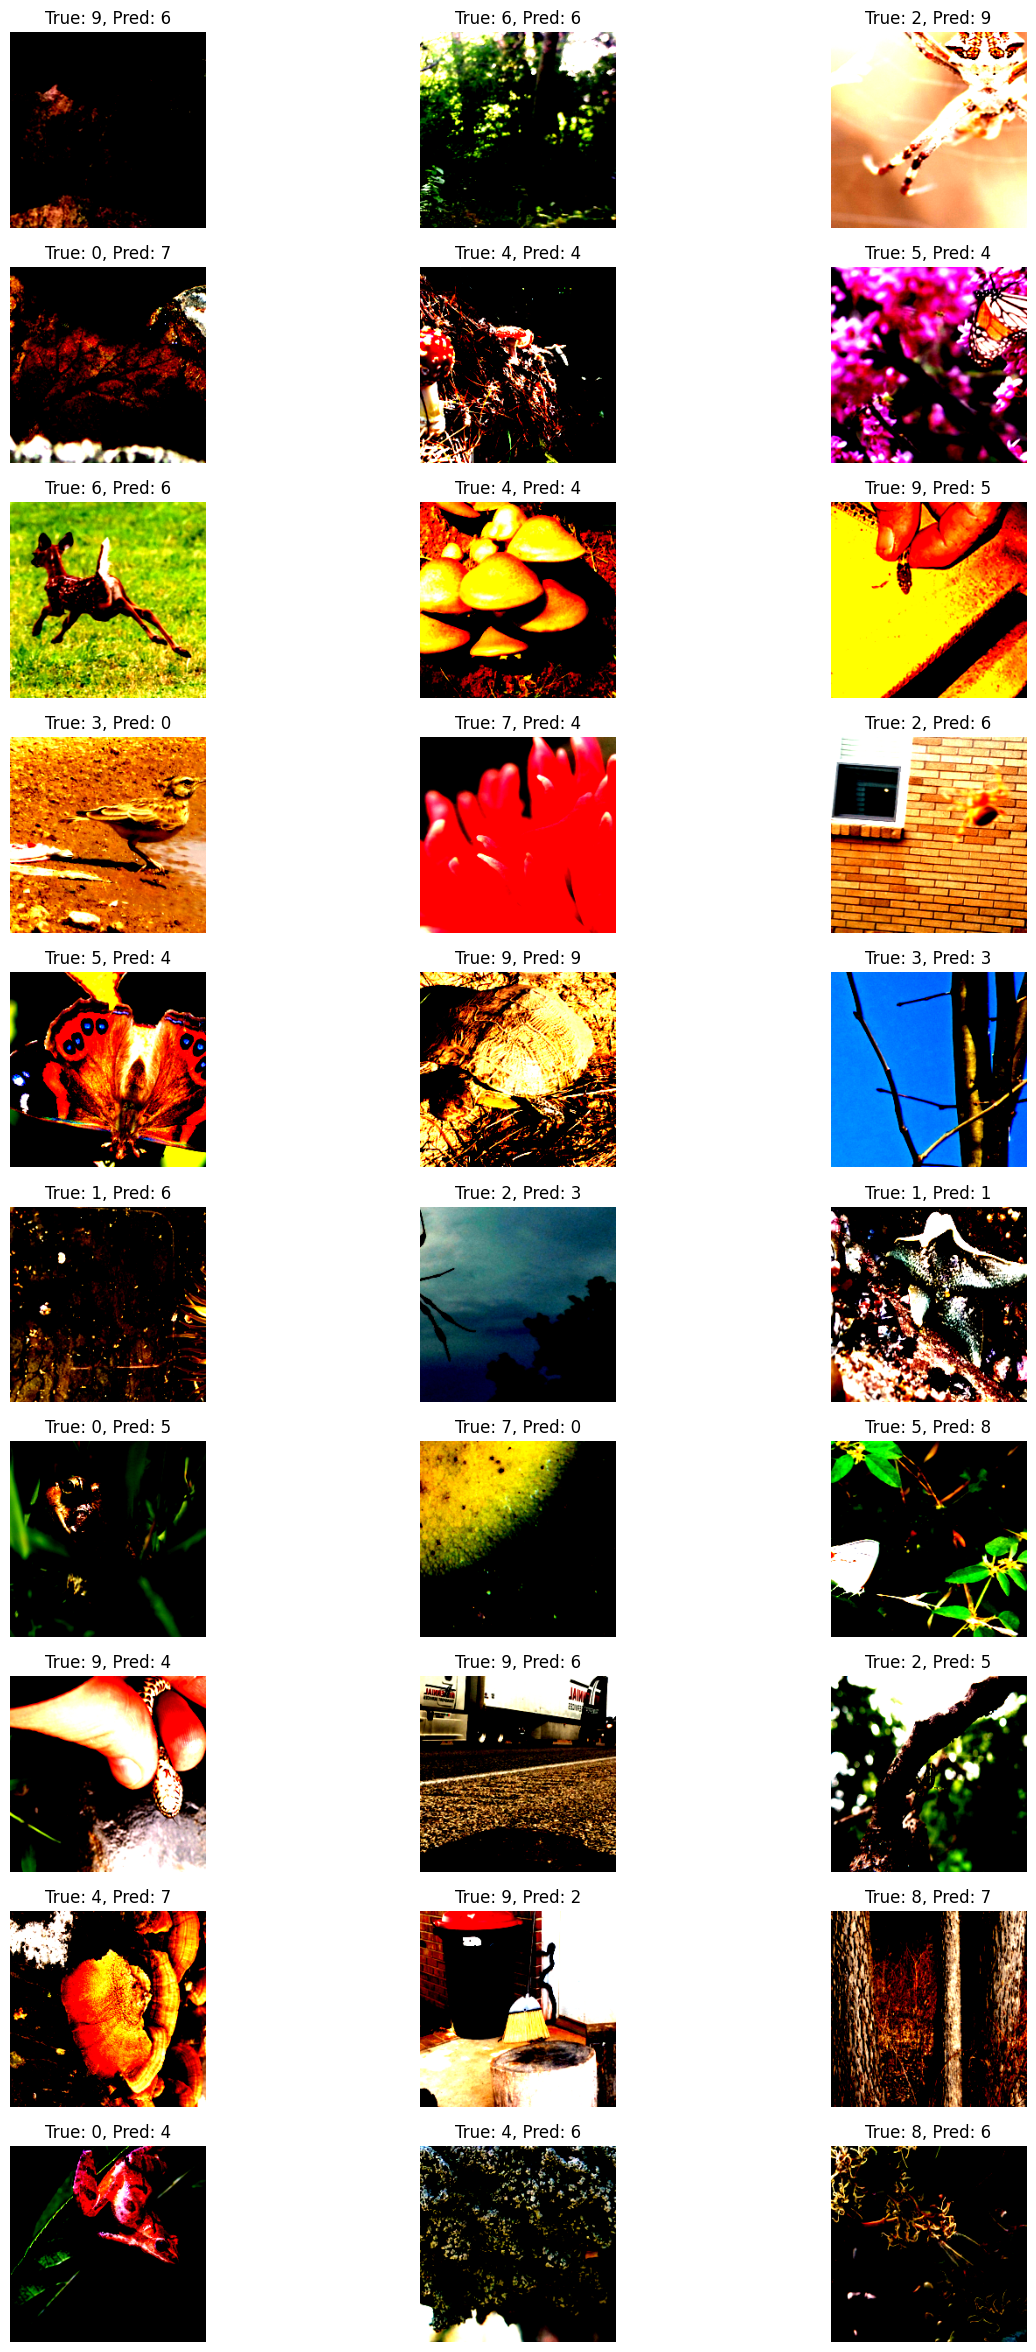

In [30]:
# this is for checking accuracy in test dataset
def main():
    # Initialize a new wandb run
    with wandb.init() as run:
        run_name = "-ac-"+wandb.config.activation_fn+"-filters-"+str(wandb.config.num_filters)+"-filt_size-"+str(wandb.config.filter_sizes)+"-dropout-"+str(wandb.config.dropout)+"-batch_norm-"+wandb.config.batch_norm+"-data_aug-"+wandb.config.data_augment+"-num_neurons_dense-"+str(wandb.config.num_neurons_dense)
        wandb.run.name=run_name
        # Model object creation
        model = my_CNN(num_classes = 10,
                  num_filters = wandb.config.num_filters,
                  filter_sizes = wandb.config.filter_sizes,
                  activation_fn = wandb.config.activation_fn,
                  num_neurons_dense = wandb.config.num_neurons_dense,
                  dropout_rate = wandb.config.dropout,
                  use_batchnorm = wandb.config.batch_norm)
        
        data_augment = wandb.config.data_augment
        train_loader, test_loader = prepare_data_loaders_for_test(data_augment)
        # Model training
        model.train_and_evaluate(train_loader, test_loader, n_epochs=8, lr=0.001)        

wandb.agent(sweep_id, function=main, count=1)  
wandb.finish()